## COGS118A - Final Project
### by Justin Laughlin and Stuart Sonatina

#### SMS dataset

In [15]:
# Import packages
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import pandas as pd
import seaborn as sns
sns.set(style="whitegrid", palette="muted")

# Splitting, training, and testing
import sklearn.model_selection as ms

# Text wrangling
import sklearn.feature_extraction.text as txt
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
import sklearn.naive_bayes as nb

# Visualization
import sklearn.metrics as skm

# magic command to display plots inline
%matplotlib inline

Tutorial
http://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

Dataset
https://www.kaggle.com/uciml/sms-spam-collection-dataset

In [2]:
# Use pandas to import data into dataframe
df = pd.read_csv('spam_v_ham.csv', encoding='latin1')
df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df.columns = ['Class', 'Message']

# replace ham with 0 and spam with 1
df['Class'].replace(['ham','spam'],[0,1],inplace=True)
df.head()

,Class,Message
0,0,"Go until jurong point, crazy.. Available only ..."
1,0,Ok lar... Joking wif u oni...
2,1,Free entry in 2 a wkly comp to win FA Cup fina...
3,0,U dun say so early hor... U c already then say...
4,0,"Nah I don't think he goes to usf, he lives aro..."


In [3]:
# create lists for features, X, and classes, Y
X = df['Message'].tolist()
X = [str(i) for i in X]
#Y = df['Class'].tolist()
Y = df['Class'].as_matrix()
Y = [int(i) for i in Y]

[Xtrain, Xtest, Ytrain, Ytest] = ms.train_test_split(X, Y, train_size=0.8)
len(Xtrain)

4457

## Workflow

In [4]:
# Tokenizing
count_vec = txt.CountVectorizer(lowercase=False, ngram_range=(1,1))
X_train_counts = count_vec.fit_transform(Xtrain)
X_test_counts = count_vec.transform(Xtest)
# print(X_train_counts.shape)

# Term Frequency times Inverse Document Frequency
tfidf_transformer = txt.TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)
print(X_train_tfidf.shape)
print(X_test_tfidf.shape)

# train Naive-Bayes Multinomial classifier
example_clf = nb.MultinomialNB().fit(X_train_tfidf, Ytrain)
example_clf.score(X_test_tfidf, Ytest)

(4457, 9577)
(1115, 9577)


0.95426008968609866

## Train classifiers
[SGD Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier)

[Multinomial Naive Bayes Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html#sklearn.naive_bayes.MultinomialNB)

In [5]:
# In order to make the vectorizer => transformer => classifier easier to work with,
# scikit-learn provides a Pipeline class that behaves like a compound classifier:

# Multinomial Naive Bayes
MNB_clf = Pipeline([('vect', txt.CountVectorizer()),
                    ('tfidf', txt.TfidfTransformer()),
                    ('clf', nb.MultinomialNB()),
                    ])
# Stochastic Gradient Descent (SGD) (Support Vector Machine)
SGD_clf = Pipeline([('vect', txt.CountVectorizer()),
                    ('tfidf', txt.TfidfTransformer()),
                    ('clf', SGDClassifier(loss='hinge', penalty='l2',
                        n_iter=5, random_state=42)),
                    ])


In [25]:
# Use grid search to find best parameters for SGD classifier
SGD_params = {'vect__ngram_range': [(1, 1), (1, 2)],
              'vect__lowercase': (True, False),
              'tfidf__use_idf': (True, False),
              'clf__alpha': (1e-2, 1e-3),
}
GS_clf = ms.GridSearchCV(SGD_clf, SGD_params, n_jobs=-1)

In [26]:
# Fit models to data
SGD_GS_clf = GS_clf.fit(Xtrain, Ytrain)
MNB_clf = MNB_clf.fit(Xtrain, Ytrain)

## Results

In [27]:
print("Best Training Score for SGD: {:.1f}%".format(SGD_GS_clf.best_score_*100))

print("\nBest Parameters:")
for param_name in sorted(SGD_params.keys()):
    print("%s: %r" % (param_name, GS_clf.best_params_[param_name]))

print("Scores on test dataset:")
print("SGD: {:.1f} %".format((SGD_GS_clf.score(Xtest, Ytest))*100))
print("MNB: {:.1f} %".format((MNB_clf.score(Xtest, Ytest))*100))


Best Training Score for SGD: 97.9%

Best Parameters:
clf__alpha: 0.001
tfidf__use_idf: False
vect__lowercase: True
vect__ngram_range: (1, 2)
Scores on test dataset:
SGD: 97.4 %
MNB: 95.5 %


[ 0.          0.00102987  1.        ]


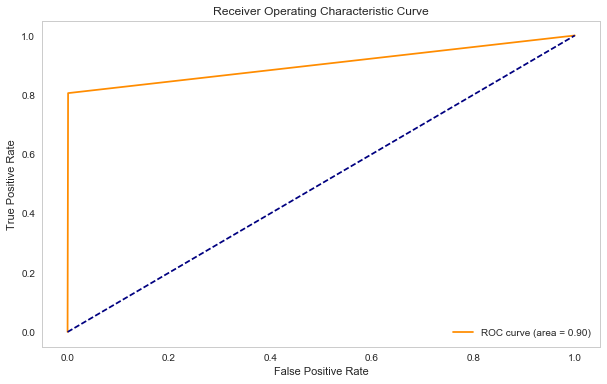

In [14]:
# predicted values
Yscore = SGD_GS_clf.predict(Xtest)

# false and true positive rates
fpr, tpr, thr = skm.roc_curve(np.array(Ytest), Yscore)

print(fpr)

# area under ROC curve
roc_auc = skm.auc(fpr, tpr)

plt.figure(figsize=[10,6])
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.grid(False)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic Curve')
plt.legend(loc="lower right")


In [28]:
precision, recall, thresholds = skm.precision_recall_curve(Ytest, Yscore, pos_label=1)

print("Precision: \t{}".format(precision))
print("Recall: \t{}".format(recall))
print("Thresholds: \t{}".format(thresholds))

F = 2*(precision[1]*recall[1])/(precision[1]+recall[1])
print(F)

Precision: 	[ 0.12914798  0.99145299  1.        ]
Recall: 	[ 1.          0.80555556  0.        ]
Thresholds: 	[0 1]
0.888888888889
